In [27]:
import xarray as xr
import numpy as np
from c_error_predictor import BiasPredictor
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Running bias predictor using the best sample and default samples from database

In [28]:
# dataset based on minimum squared bias 
xr_data_cal=xr.load_dataset("results_stacked_hh_best_sample.nc")
# Running predictor for calibrated data
predictor = BiasPredictor(xr_data_cal)
results=predictor.run()
cv_df,cv_df_xgb,cv_df_linear_reduced,cv_df_xgb_reduced = results["linear"],results["xgb"],results["linear_reduced"],results["xgb_reduced"]

# # dataset using baseline parameters 
xr_data_def=xr.load_dataset("results_stacked_hh_default_sample.nc")
predictor = BiasPredictor(xr_data_def)
results_def=predictor.run()
cv_df_def,cv_df_xgb_def,cv_df_linear_reduced_def,cv_df_xgb_reduced_def = results_def["linear"],results_def["xgb"],results_def["linear_reduced"],results_def["xgb_reduced"]


Preprocessing the data...
Nested cross validation... hyperparameter optimization and evaluation on unseen data in each fold
Preprocessing the data...
Nested cross validation... hyperparameter optimization and evaluation on unseen data in each fold


# Comparing Cross Validation Stats for different regression models with and without dimension reduction

In [29]:
def plot_cv_metrics(dfs_combined, metric='r2', plot=True):

    fs=14
    positions = [1, 2, 4, 5, 7, 8, 10, 11]
    box_colors = ['grey', 'blue'] * 4  # grey for default, blue for calibrated

    fig, ax = plt.subplots(figsize=(8, 6))

    data = [df[metric] for df, _ in dfs_combined]
    bp = ax.boxplot(
        data, positions=positions, widths=0.7, patch_artist=True, showmeans=True
    )
    ax.set_title("Cross-validation comparison for different bias predictor pipelines",fontsize=fs)
    ax.set_ylabel(metric.upper(), fontsize=fs)
    ax.grid(axis='y')

    # Set box colors
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
    for median in bp['medians']:
        median.set_color('black')

    ax.set_xticks([np.mean(positions[j:j+2]) for j in range(0, len(positions), 2)])
    ax.set_xticklabels(["Linear", "XGB", "Linear\n(Red. Dims)", "XGB\n(Red. Dims)"], 
                       rotation=0, ha='center', fontsize=fs)
    ax.tick_params(axis='both', labelsize=fs)

    legend_handles = [
        Patch(facecolor='grey', label='Default'),
        Patch(facecolor='blue', label='Calibrated')
    ]
    plt.legend(handles=legend_handles, title="Model Parameters")

    plt.tight_layout()
    if plot:
        plt.savefig(f"cv_bars_{metric}.png")

    plt.show()

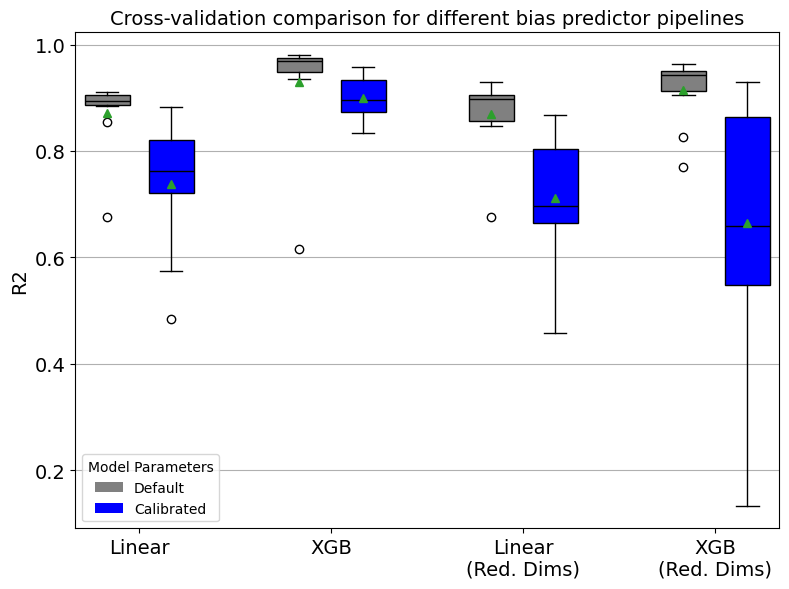

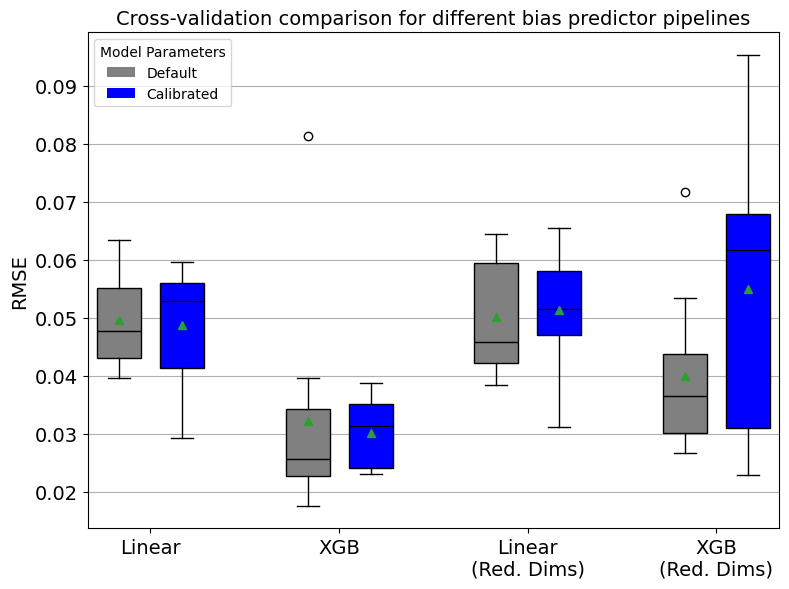

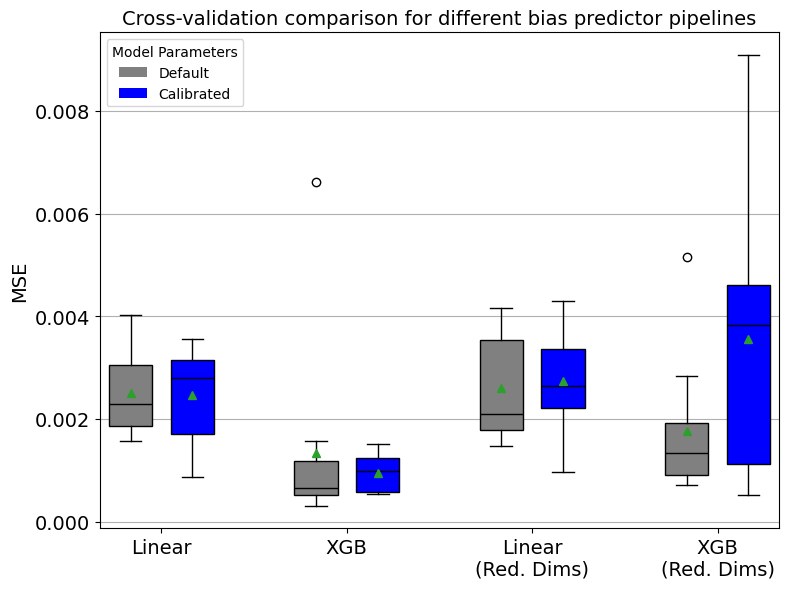

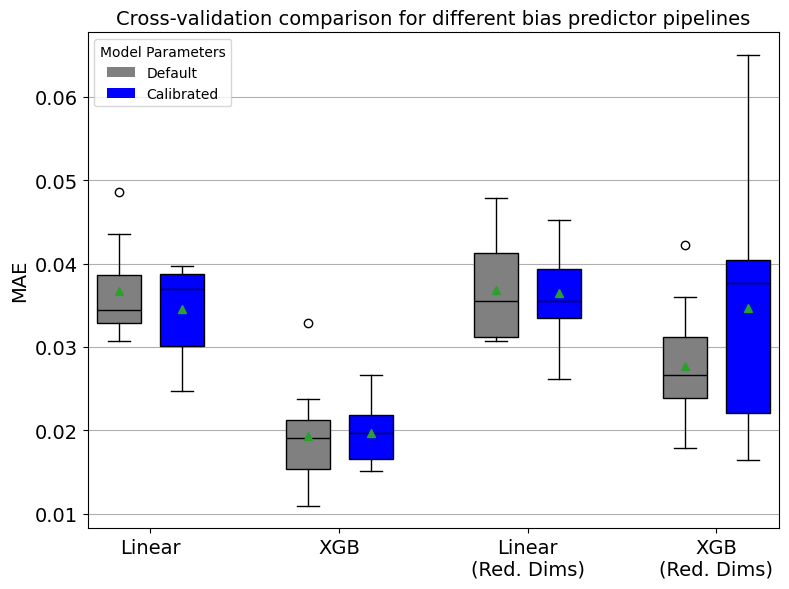

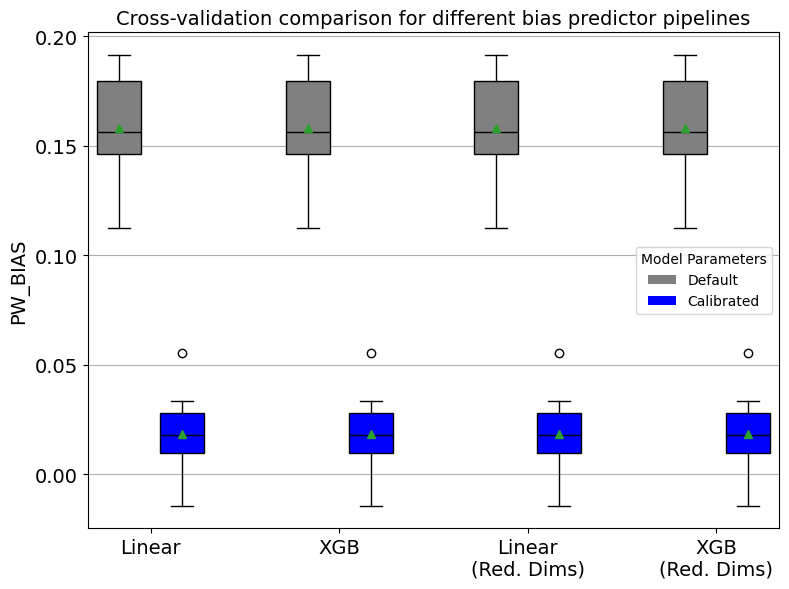

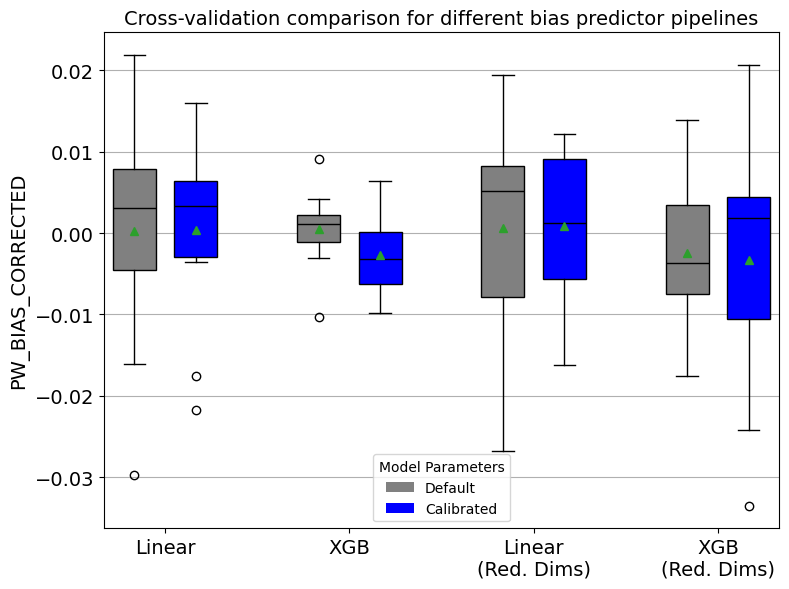

In [30]:
dfs_combined = [
    (cv_df_def, "Linear (Default)"),
    (cv_df, "Linear (Calibrated)"),
    (cv_df_xgb_def, "XGB (Default)"),
    (cv_df_xgb, "XGB (Calibrated)"),
    (cv_df_linear_reduced_def, "Linear (Red. Dims, Default)"),
    (cv_df_linear_reduced, "Linear (Red. Dims, Calibrated)"),
    (cv_df_xgb_reduced_def, "XGB (Red. Dims, Default)"),
    (cv_df_xgb_reduced, "XGB (Red. Dims, Calibrated)")
]
plot_cv_metrics(dfs_combined, metric='r2')
plot_cv_metrics(dfs_combined, metric='rmse')
plot_cv_metrics(dfs_combined, metric='mse')
plot_cv_metrics(dfs_combined, metric='mae')
plot_cv_metrics(dfs_combined, metric='pw_bias')
plot_cv_metrics(dfs_combined, metric='pw_bias_corrected')

# Choosing best predictor (xgb) and comparing 4 model levels
4 model levels:
- pywake default parameters
- pywake calibrated parameters
- pywake default parameters + bias correction
- pywake calibrated parameters + bias correction




In [31]:
bias_default=cv_df_xgb_def['pw_bias']
bias_default_corrected=cv_df_xgb_def['pw_bias_corrected']
bias_calibrated=cv_df_xgb['pw_bias']
bias_calibrated_corrected=cv_df_xgb['pw_bias_corrected']

/tmp/ipykernel_60985/1727955271.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(biases, labels=xlabels)


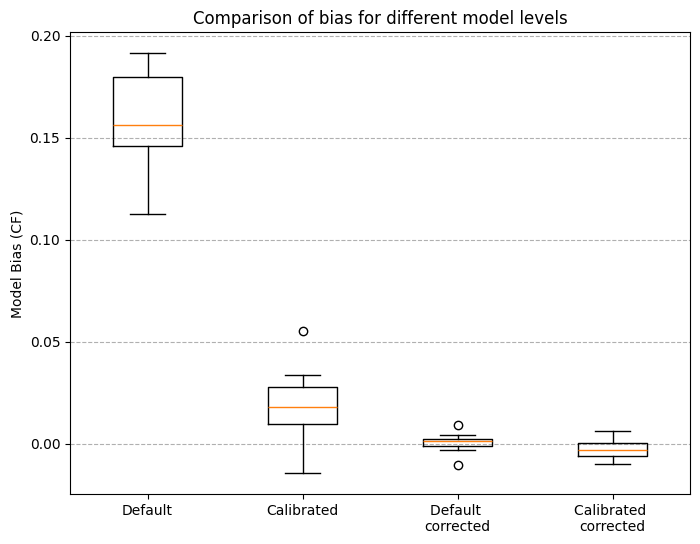

In [32]:
biases = [
    bias_default,
    bias_calibrated,
    bias_default_corrected,
    bias_calibrated_corrected
]

xlabels = ['Default','Calibrated','Default \ncorrected','Calibrated \ncorrected']
plt.figure(figsize=(8,6))
plt.boxplot(biases, labels=xlabels)
plt.ylabel("Model Bias (CF)")
plt.title("Comparison of bias for different model levels")
plt.grid(axis='y', linestyle='--')
plt.show()

# Effect of calibration on distribution of bias

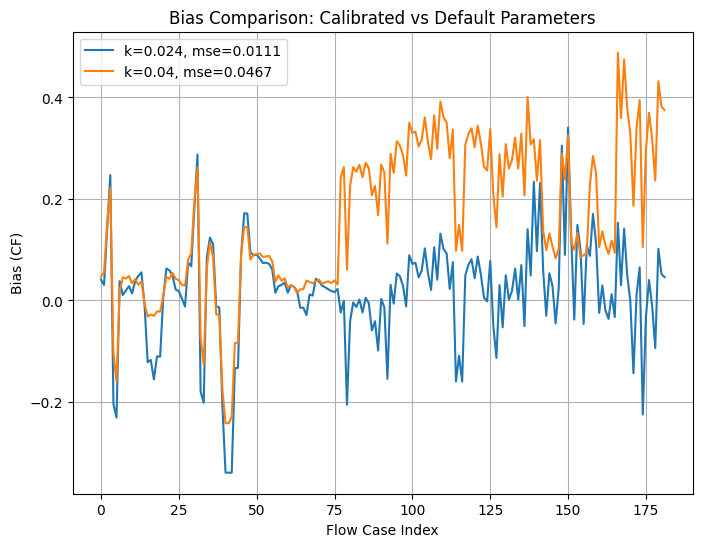

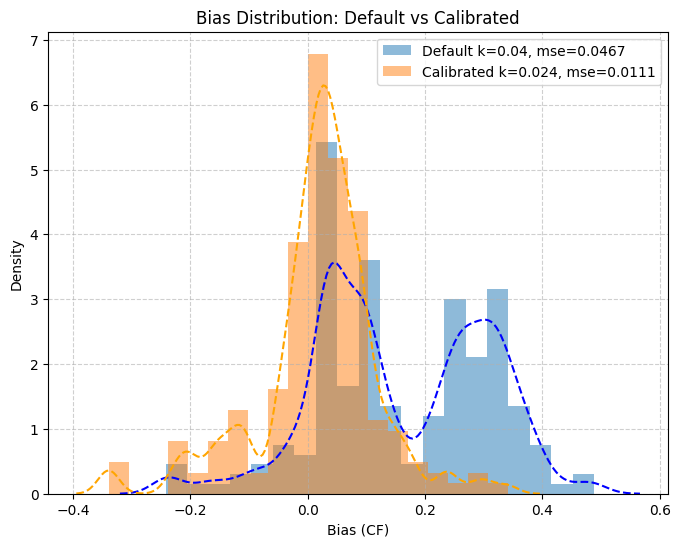

In [37]:
bias_cal=xr_data_cal.model_bias_cap.values
cal_mse=round(np.mean(bias_cal**2),4)
bias_default=xr_data_def.model_bias_cap.values.flatten()
default_mse=round(np.mean(bias_default**2),4)


plt.figure(figsize=(8,6))
plt.plot(bias_cal,label=f"k=0.024, mse={cal_mse}")
plt.plot(bias_default,label=f"k=0.04, mse={default_mse}")
plt.ylabel("Bias (CF)")
plt.xlabel("Flow Case Index")
plt.title("Bias Comparison: Calibrated vs Default Parameters")
plt.grid()
plt.legend()

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))

plt.hist(bias_default, bins=20, alpha=0.5, label=f"Default k=0.04, mse={default_mse}", density=True)
plt.hist(bias_cal, bins=20, alpha=0.5, label=f"Calibrated k=0.024, mse={cal_mse}", density=True)

# Optional KDE / curve fitting
sns.kdeplot(bias_default, bw_adjust=0.5, color='blue', linestyle='--')
sns.kdeplot(bias_cal, bw_adjust=0.5, color='orange', linestyle='--')

plt.xlabel("Bias (CF)")
plt.ylabel("Density")
plt.title("Bias Distribution: Default vs Calibrated")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()